In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']



data_path = '/content/gdrive/MyDrive/data-unversioned/p1ch7'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Mounted at /content/gdrive
Files already downloaded and verified
Files already downloaded and verified


In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [5]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.shape, img.unsqueeze(0).shape, output.shape

(torch.Size([3, 32, 32]),
 torch.Size([1, 3, 32, 32]),
 torch.Size([1, 16, 30, 30]))

In [8]:
# Padding to preserve the size of the image
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [9]:
# Setting constant 0 bias and average of weights for weight
with torch.no_grad():
  conv.bias.zero_()

with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)

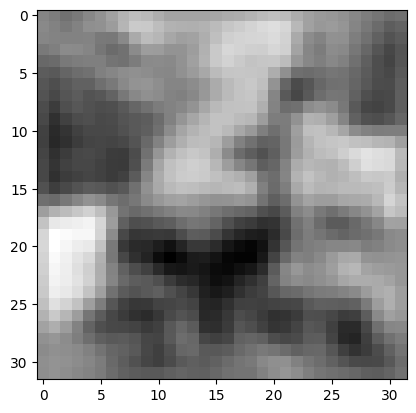

In [12]:
# Image is blurred
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

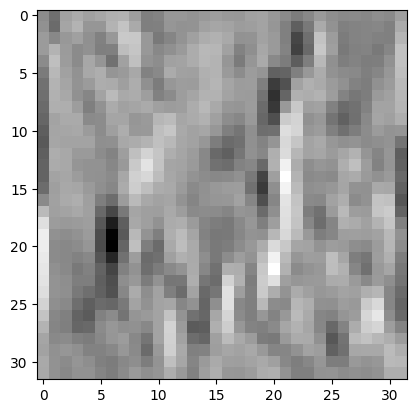

In [13]:
# Edge detection kernel
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
  conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                 [-1.0, 0.0, 1.0],
                                 [-1.0, 0.0, 1.0]])
  conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()


In [14]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [5]:
import torch
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8*8*8) # Need reshaping
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out


In [16]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [6]:
import torch
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8*8*8) # Need reshaping
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out


In [25]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0027, -0.0747]], grad_fn=<AddmmBackward0>)

In [7]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      outputs = model(imgs)

      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch % 10 == 0:
      print(f'Epoch: {epoch}, Training loss {loss_train / len(train_loader)}')

In [8]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

training_loop(
    n_epochs=100,
    optimizer = optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Epoch: 10, Training loss 0.33222581825818226
Epoch: 20, Training loss 0.29116153764496944
Epoch: 30, Training loss 0.2659087325357328
Epoch: 40, Training loss 0.246705945415102
Epoch: 50, Training loss 0.22854591341345173
Epoch: 60, Training loss 0.21393183025584858
Epoch: 70, Training loss 0.19710224814665545
Epoch: 80, Training loss 0.18139379239006406
Epoch: 90, Training loss 0.1672693933745858
Epoch: 100, Training loss 0.15321764352310235


In [13]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

def validate(model, train_loader, val_loader):
  for name, loader in [('train', train_loader), ('val', val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)

        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print('Accuracy {}: {:.2f}'.format(name, correct / total))

validate(model, train_loader, val_loader)


Accuracy train: 0.92
Accuracy val: 0.88


In [19]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/data-unversioned/p1ch7/birds_vs_airplanes.pt')

In [20]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('/content/gdrive/MyDrive/data-unversioned/p1ch7/birds_vs_airplanes.pt'))


<All keys matched successfully>

In [21]:
import torch
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 16*8*8) # Need reshaping
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [22]:
import torch
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1=n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8*8*n_chans1 // 2) # Need reshaping
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [23]:
model = Net()
sum(p.numel() for p in model.parameters())

38386

In [26]:
[p.numel() for p in model.parameters()]

[864, 32, 4608, 16, 32768, 32, 64, 2]

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs+1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      l2_lambda = 0.001
      l2_norm = sum(p.pow(2.0).sum()
                    for p in model.parameters())
      loss = loss + l2_lambda*l2_norm
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train = loss.item()
    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training Loss {}'.format(
          datetime.datetime.now(), epoch,
          loss_train = len(train_loader)
      ))

In [4]:
import torch
import torch.nn as nn

class NetDropout(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_dropout = nn.Dropout2d(p=0.4)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv2_dropout = nn.Dropout2d(p=0.4)
    self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = self.conv1_dropout(out)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = self.conv2_dropout(out)
    out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out



In [ ]:
class NetBatchNorm(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
    self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.conv1_batchnorm(self.conv1(x))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = self.conv2_batchnorm(self.conv2(out))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out


In [3]:
import torch.nn as nn

class NetDepth(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
    out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)


In [ ]:
class NetRes(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out1 = out
    out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
    out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)



In [ ]:
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight,
                                  nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.bath_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [ ]:
class NetResDeep(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=10):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(
        *(n_blocks * [ResBlock(n_chans=n_chans1)]))
    self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8 * 8 * n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

